In [1]:
import gc
import os
from itertools import islice

from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
from transformers import pipeline, CLIPModel, CLIPProcessor
from tqdm import tqdm

# Configuration
LOADER_PATCH_SIZE = 32
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Cuda Availability:{torch.cuda.is_available()} Training on {device}")

Cuda Availability:True Training on cuda


# Notebook for interactive testing for CLIP

In [2]:

class Cfg:
    model_id: str = "openai/clip-vit-base-patch32"
    batch_size: int = 32
    epochs: int = 40
    seed:   int = 42

    lr_head: float = 1e-3      
    wd_head: float = 1e-4
    lr_lora: float = 1e-4
    wd_lora: float = 1e-2
    lambda_text: float = 0.3

    early_stopping: bool = True
    early_stop_patience = 3
    early_stop_minimum_improvement:float = 0.02


    lora_rank: int = 8
    lora_alpha: int = 16
    lora_dropout: float = 0.0
    lora_target: tuple = ("q_proj","k_proj","v_proj","out_proj")  

    amp: bool = True

cfg = Cfg()

PREPROCESS_DATA_ROOT = "data/preprocessed"
torch.manual_seed(cfg.seed)
model_id = "openai/clip-vit-base-patch32"
clip_model = CLIPModel.from_pretrained(model_id).to(device).eval()
processor  = CLIPProcessor.from_pretrained(model_id)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [3]:
def collate_pil(batch):
    images, labels = zip(*batch) 
    return list(images), torch.tensor(labels) 

def preprocess_dataset(split="train",data_root='data',outputdir="data/preprocessed",batchsize=cfg.batch_size,fp16=False):
    os.makedirs(outputdir,exist_ok=True)
    dataset = datasets.Flowers102(root=data_root, split=split, download=True)
    classes = dataset.classes
    loader = DataLoader(dataset, batch_size=batchsize, shuffle= True if split=="train" else False, num_workers=0,collate_fn=collate_pil)

    N = len(dataset)
    C, H, W = 3, 224, 224
    pixels = torch.empty((N,C,H,W), dtype=torch.float32 if not fp16 else torch.float16)
    labels = torch.empty(N, dtype=torch.long)

    print(f"Preprocessing {split} data...")

    index = 0
    with torch.no_grad():
        for images, y in tqdm(loader,desc=f"Preprocessing {split}"):
            pix = processor(images=images,return_tensors="pt")['pixel_values']
            if fp16:
                pix = pix.half()
            b = pix.size(0) 
            pixels[index:index+b] = pix
            labels[index:index+b] = y
            index += b


    out_path = os.path.join(outputdir, f"{split}.pt")
    torch.save({"pixel_values": pixels, "labels": labels, "fp16": fp16,"classes":classes}, out_path)
    print(f"Saved → {out_path} (pixels: {pixels.shape}, dtype={pixels.dtype})")

    print("Performing Garbage Cleaning...")
    del pixels, labels
    torch.cuda.empty_cache()
    gc.collect()

    %reset_selective -f pixels
    %reset_selective -f labels

class CacheDataset:
    def __init__(self, split="train", root="data/preprocessed"):
        path = os.path.join(root, f"{split}.pt")
        obj = torch.load(path, map_location="cpu")
        self.pixel_values = obj["pixel_values"]
        self.labels = obj["labels"]
        self.fp16 = bool(obj.get("fp16", False))
        self.classes = obj['classes']

    def __len__(self):
        return self.labels.numel()

    def __getitem__(self, idx):
        return self.pixel_values[idx], self.labels[idx]


if not os.path.exists(os.path.join(PREPROCESS_DATA_ROOT, "train.pt")):
    preprocess_dataset(split="train",data_root="data",outputdir=PREPROCESS_DATA_ROOT,fp16=False)
if not os.path.exists(os.path.join(PREPROCESS_DATA_ROOT, "val.pt")):
    preprocess_dataset(split="val",data_root="data",outputdir=PREPROCESS_DATA_ROOT,fp16=False)
if not os.path.exists(os.path.join(PREPROCESS_DATA_ROOT, "test.pt")):
    preprocess_dataset(split="test",data_root="data",outputdir=PREPROCESS_DATA_ROOT,fp16=False)




train_set = CacheDataset(split="train")
val_set = CacheDataset(split="val")
test_set = CacheDataset(split="test")

classname = val_set.classes
classname




100%|██████████| 345M/345M [00:13<00:00, 26.3MB/s]
100%|██████████| 502/502 [00:00<00:00, 2.39MB/s]
100%|██████████| 15.0k/15.0k [00:00<00:00, 34.9MB/s]


Preprocessing train data...


Preprocessing train: 100%|██████████| 32/32 [00:09<00:00,  3.35it/s]


Saved → data/preprocessed/train.pt (pixels: torch.Size([1020, 3, 224, 224]), dtype=torch.float32)
Performing Garbage Cleaning...
Preprocessing val data...


Preprocessing val: 100%|██████████| 32/32 [00:09<00:00,  3.40it/s]


Saved → data/preprocessed/val.pt (pixels: torch.Size([1020, 3, 224, 224]), dtype=torch.float32)
Performing Garbage Cleaning...
Preprocessing test data...


Preprocessing test: 100%|██████████| 193/193 [01:14<00:00,  2.59it/s]


Saved → data/preprocessed/test.pt (pixels: torch.Size([6149, 3, 224, 224]), dtype=torch.float32)
Performing Garbage Cleaning...


['pink primrose',
 'hard-leaved pocket orchid',
 'canterbury bells',
 'sweet pea',
 'english marigold',
 'tiger lily',
 'moon orchid',
 'bird of paradise',
 'monkshood',
 'globe thistle',
 'snapdragon',
 "colt's foot",
 'king protea',
 'spear thistle',
 'yellow iris',
 'globe-flower',
 'purple coneflower',
 'peruvian lily',
 'balloon flower',
 'giant white arum lily',
 'fire lily',
 'pincushion flower',
 'fritillary',
 'red ginger',
 'grape hyacinth',
 'corn poppy',
 'prince of wales feathers',
 'stemless gentian',
 'artichoke',
 'sweet william',
 'carnation',
 'garden phlox',
 'love in the mist',
 'mexican aster',
 'alpine sea holly',
 'ruby-lipped cattleya',
 'cape flower',
 'great masterwort',
 'siam tulip',
 'lenten rose',
 'barbeton daisy',
 'daffodil',
 'sword lily',
 'poinsettia',
 'bolero deep blue',
 'wallflower',
 'marigold',
 'buttercup',
 'oxeye daisy',
 'common dandelion',
 'petunia',
 'wild pansy',
 'primula',
 'sunflower',
 'pelargonium',
 'bishop of llandaff',
 'gaura',

In [4]:
train_loader = DataLoader(
    train_set, batch_size=cfg.batch_size, shuffle=True,
    num_workers=0, pin_memory=True
)
val_loader = DataLoader(
    val_set, batch_size=cfg.batch_size, shuffle=False,
    num_workers=0, pin_memory=True
)
test_loader = DataLoader(
    test_set, batch_size=cfg.batch_size, shuffle=False,
    num_workers=0, pin_memory=True
)

---
## Model Setting and Training

In [5]:
import torch
from tqdm import tqdm

promptTemplate = {
    "A photo of {}.",
    "A photo of flower {}.",
    "Botanic picture of {}",
    "A example picture of type {}"
}

@torch.no_grad()
def build_text_embeddings(names):
    embs = []
    for name in tqdm(names, desc="TextEmbed"):
        prompts = [t.format(name.replace("_"," ")) for t in promptTemplate] 
        inputs = processor(text=prompts, return_tensors="pt", padding=True).to(device)
        te = clip_model.get_text_features(**inputs) 
        te = te / te.norm(dim=-1, keepdim=True)
        embs.append(te.mean(dim=0))         
    text = torch.stack(embs, dim=0) 
    return text / text.norm(dim=-1, keepdim=True)

text_embs = build_text_embeddings(classname)



TextEmbed: 100%|██████████| 102/102 [00:01<00:00, 63.25it/s]


----
## Building CLIP model with LoRA and word embedding.

Have to implement a LoRA linear layer ourselves.

In [6]:
import torch, torch.nn as nn
from transformers.models.clip.modeling_clip import CLIPVisionModel

class LoRALinearLayer(nn.Module):
    def __init__(self, base: nn.Linear, r=8, alpha=16, dropout=0.0):

        super().__init__()
        self.base = base 
        self.r = r
        self.scaling = alpha / r
        dev = base.weight.device
        dt  = base.weight.dtype



        if r > 0:
            self.lora_A = nn.Linear(base.in_features, r, bias=False).to(dev, dtype=dt)
            self.lora_B = nn.Linear(r, base.out_features, bias=False).to(dev, dtype=dt)
            self.dropout = nn.Dropout(dropout)
            nn.init.kaiming_uniform_(self.lora_A.weight,a=5**0.5)
            nn.init.zeros_(self.lora_B.weight) 
        else:
            self.lora_A = None
            self.lora_B = None
            self.dropout = nn.Identity()

            #Frozen
        for p in self.base.parameters():
            p.requires_grad = False

    def forward(self, x):
        if self.r > 0:
            return self.base(x) + self.dropout(self.lora_B(self.lora_A(x))) * self.scaling
        else:
            return self.base(x)



def lora_injection(clip_model: nn.Module, target_names=("q_proj","k_proj","v_proj","out_proj")):
    """
    """
    assert isinstance(clip_model.vision_model, CLIPVisionModel.__mro__[0].__class__) or hasattr(clip_model, "vision_model")
    lora_params = []
    for name, module in clip_model.vision_model.named_modules():
        for t in target_names:
            if hasattr(module, t):
                lin = getattr(module, t)
                if isinstance(lin, nn.Linear):
                    lora_lin = LoRALinearLayer(lin, r=cfg.lora_rank, alpha=cfg.lora_alpha, dropout=cfg.lora_dropout)
                    setattr(module, t, lora_lin)
                    lora_params += list(lora_lin.lora_A.parameters()) + list(lora_lin.lora_B.parameters())
    for p in clip_model.vision_model.parameters():
        p.requires_grad = False
    for p in lora_params:
        p.requires_grad = True
    return lora_params

def build_head_and_optim(clip_model: CLIPModel):
    feat_dim = clip_model.config.projection_dim  
    head = nn.Linear(feat_dim, 102).to(device)

    lora_params = lora_injection(clip_model, target_names=cfg.lora_target)
    clip_model.to(device)

    optim = torch.optim.AdamW(
        [
            {"params": head.parameters(),      "lr": cfg.lr_head, "weight_decay": cfg.wd_head},
            {"params": lora_params,            "lr": cfg.lr_lora, "weight_decay": cfg.wd_lora},
        ]
    )
    scaler = torch.amp.GradScaler(enabled=(device=="cuda" and cfg.amp))
    return head, optim, scaler


In [7]:
head, optimizer, scaler = build_head_and_optim(clip_model)
ce = torch.nn.CrossEntropyLoss()

def get_image_feats(images):

    if isinstance(images, torch.Tensor):
        pixel_values = images.to(device, dtype=torch.float16 if (device=="cuda" and cfg.amp) else torch.float32)
    else:
        inputs = processor(images=images, return_tensors="pt").to(device)
        pixel_values = inputs["pixel_values"]

    feats = clip_model.get_image_features(pixel_values=pixel_values) 
    feats = feats / feats.norm(dim=-1, keepdim=True)
    return feats

def supervised_logits(feats):
    return head(feats)

def text_logits(feats):
    return (feats @ text_embs.T) * clip_model.logit_scale.exp()


----
## Main Training Epoch

In [8]:
class EarlyStopper:
    def __init__(self):
        self.counter = 0
        self.last_loss = 0
        self.patience = cfg.early_stop_patience
        self.enable = cfg.early_stopping
        self.delta = cfg.early_stop_minimum_improvement
    def report(self,loss):
        if self.last_loss - loss < self.delta:
            self.counter += 1
        else:
            self.counter = 0
        self.last_loss = loss

    def stop_flag(self):
        return self.enable and (self.counter >= self.patience)

def run_epoch(loader: DataLoader, train: bool=True):
    if train:
        head.train()
        clip_model.train()
    else:
        head.eval()
        clip_model.eval()

    total, correct_cls, correct_txt = 0, 0, 0
    loss_sum = 0.0
    for images, labels in tqdm(loader, desc="Train" if train else "Eval"):
        labels = labels.to(device)
        with torch.amp.autocast(device_type=device,enabled=(device=="cuda" and cfg.amp)):
            feats = get_image_feats(images)

            logits_cls = supervised_logits(feats) 
            loss_cls = ce(logits_cls, labels)

            logits_txt = text_logits(feats) 
            loss_txt = ce(logits_txt, labels)


            loss = loss_cls + cfg.lambda_text * loss_txt 


        if train:
            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

        loss_sum += loss.item() * labels.size(0)
        total += labels.size(0)
        correct_cls += (logits_cls.argmax(dim=-1) == labels).sum().item()
        correct_txt += (logits_txt.argmax(dim=-1) == labels).sum().item()

    loss_avg = loss_sum / total

    return {
    "loss": loss_avg,
    "acc_cls": correct_cls/total,   
    "acc_txt": correct_txt/total,
}



In [18]:
best_val = -1.0
best_head = None
earlystop = EarlyStopper()
for ep in range(1,cfg.epochs+1):
    training = run_epoch(train_loader, train=True)
    val = run_epoch(val_loader, train=False)
    print(f"[{ep}/{cfg.epochs}] "
          f"Train: loss={training['loss']:.4f} acc_cls={training['acc_cls']:.4f} acc_txt={training['acc_txt']:.4f} | "
          f"Val:   loss={val['loss']:.4f} acc_cls={val['acc_cls']:.4f} acc_txt={val['acc_txt']:.4f}")


    if val["acc_cls"] > best_val:
        best_val = val["acc_cls"]
        best_head = { k: v.detach().cpu() for k, v in head.state_dict().items() } 
    if earlystop.stop_flag():
        print(f"Early stop triggered...Exiting on epoch {ep}")

if best_head is not None:
    head.load_state_dict({k: v.to(device) for k, v in best_head.items()})
te = run_epoch(test_loader, train=False)
print(f"Test: loss={te['loss']:.4f}  acc_cls={te['acc_cls']:.4f}  acc_txt={te['acc_txt']:.4f}")


Eval: 100%|██████████| 32/32 [00:01<00:00, 24.81it/s]


[1/40] Train: loss=5.0605 acc_cls=0.0382 acc_txt=0.6578 | Val:   loss=4.9554 acc_cls=0.1725 acc_txt=0.7020


Eval: 100%|██████████| 32/32 [00:01<00:00, 24.70it/s]


[2/40] Train: loss=4.8601 acc_cls=0.3578 acc_txt=0.7225 | Val:   loss=4.7804 acc_cls=0.5245 acc_txt=0.7461


Eval: 100%|██████████| 32/32 [00:01<00:00, 24.62it/s]


[3/40] Train: loss=4.6129 acc_cls=0.7490 acc_txt=0.8078 | Val:   loss=4.5712 acc_cls=0.7990 acc_txt=0.7912


Eval: 100%|██████████| 32/32 [00:01<00:00, 24.75it/s]


[4/40] Train: loss=4.3281 acc_cls=0.9137 acc_txt=0.8873 | Val:   loss=4.3523 acc_cls=0.8686 acc_txt=0.8049


Eval: 100%|██████████| 32/32 [00:01<00:00, 24.70it/s]


[5/40] Train: loss=4.0508 acc_cls=0.9549 acc_txt=0.9529 | Val:   loss=4.1288 acc_cls=0.8735 acc_txt=0.8137


Eval: 100%|██████████| 32/32 [00:01<00:00, 24.72it/s]


[6/40] Train: loss=3.7849 acc_cls=0.9667 acc_txt=0.9755 | Val:   loss=3.9163 acc_cls=0.8814 acc_txt=0.8186


Eval: 100%|██████████| 32/32 [00:01<00:00, 24.81it/s]


[7/40] Train: loss=3.5335 acc_cls=0.9784 acc_txt=0.9863 | Val:   loss=3.7264 acc_cls=0.8971 acc_txt=0.8069


Eval: 100%|██████████| 32/32 [00:01<00:00, 24.57it/s]


[8/40] Train: loss=3.3036 acc_cls=0.9843 acc_txt=0.9902 | Val:   loss=3.5309 acc_cls=0.8980 acc_txt=0.8098


Eval: 100%|██████████| 32/32 [00:01<00:00, 24.71it/s]


[9/40] Train: loss=3.0815 acc_cls=0.9912 acc_txt=0.9941 | Val:   loss=3.3423 acc_cls=0.9059 acc_txt=0.8118


Eval: 100%|██████████| 32/32 [00:01<00:00, 23.26it/s]


[10/40] Train: loss=2.8729 acc_cls=0.9902 acc_txt=0.9971 | Val:   loss=3.1774 acc_cls=0.9029 acc_txt=0.8010


Eval: 100%|██████████| 32/32 [00:01<00:00, 24.55it/s]


[11/40] Train: loss=2.6698 acc_cls=0.9912 acc_txt=0.9971 | Val:   loss=3.0121 acc_cls=0.9049 acc_txt=0.8078


Eval: 100%|██████████| 32/32 [00:01<00:00, 24.72it/s]


[12/40] Train: loss=2.4755 acc_cls=0.9951 acc_txt=0.9990 | Val:   loss=2.8765 acc_cls=0.9039 acc_txt=0.8010


Eval: 100%|██████████| 32/32 [00:01<00:00, 21.98it/s]


[13/40] Train: loss=2.2855 acc_cls=0.9961 acc_txt=0.9990 | Val:   loss=2.7142 acc_cls=0.9039 acc_txt=0.8039


Eval: 100%|██████████| 32/32 [00:01<00:00, 24.83it/s]


[14/40] Train: loss=2.1024 acc_cls=0.9980 acc_txt=0.9980 | Val:   loss=2.5678 acc_cls=0.9029 acc_txt=0.8167


Eval: 100%|██████████| 32/32 [00:01<00:00, 24.68it/s]


[15/40] Train: loss=1.9284 acc_cls=0.9980 acc_txt=1.0000 | Val:   loss=2.4732 acc_cls=0.9020 acc_txt=0.7951


Eval: 100%|██████████| 32/32 [00:01<00:00, 21.57it/s]


[16/40] Train: loss=1.7602 acc_cls=1.0000 acc_txt=1.0000 | Val:   loss=2.3323 acc_cls=0.9108 acc_txt=0.7961


Eval: 100%|██████████| 32/32 [00:01<00:00, 24.81it/s]


[17/40] Train: loss=1.6019 acc_cls=1.0000 acc_txt=1.0000 | Val:   loss=2.2160 acc_cls=0.9127 acc_txt=0.7941


Eval: 100%|██████████| 32/32 [00:01<00:00, 24.89it/s]


[18/40] Train: loss=1.4521 acc_cls=1.0000 acc_txt=1.0000 | Val:   loss=2.1094 acc_cls=0.9147 acc_txt=0.7990


Eval: 100%|██████████| 32/32 [00:01<00:00, 22.23it/s]


[19/40] Train: loss=1.3131 acc_cls=1.0000 acc_txt=1.0000 | Val:   loss=2.0085 acc_cls=0.9216 acc_txt=0.7882


Eval: 100%|██████████| 32/32 [00:01<00:00, 24.78it/s]


[20/40] Train: loss=1.1826 acc_cls=1.0000 acc_txt=1.0000 | Val:   loss=1.9215 acc_cls=0.9206 acc_txt=0.7824


Eval: 100%|██████████| 32/32 [00:01<00:00, 24.88it/s]


[21/40] Train: loss=1.0635 acc_cls=1.0000 acc_txt=1.0000 | Val:   loss=1.8568 acc_cls=0.9186 acc_txt=0.7735


Eval: 100%|██████████| 32/32 [00:01<00:00, 22.96it/s]


[22/40] Train: loss=0.9548 acc_cls=1.0000 acc_txt=1.0000 | Val:   loss=1.7731 acc_cls=0.9167 acc_txt=0.7784


Eval: 100%|██████████| 32/32 [00:01<00:00, 24.88it/s]


[23/40] Train: loss=0.8566 acc_cls=1.0000 acc_txt=1.0000 | Val:   loss=1.6872 acc_cls=0.9216 acc_txt=0.7814


Eval: 100%|██████████| 32/32 [00:01<00:00, 25.01it/s]


[24/40] Train: loss=0.7682 acc_cls=1.0000 acc_txt=1.0000 | Val:   loss=1.6450 acc_cls=0.9167 acc_txt=0.7794


Eval: 100%|██████████| 32/32 [00:01<00:00, 23.98it/s]


[25/40] Train: loss=0.6896 acc_cls=1.0000 acc_txt=1.0000 | Val:   loss=1.5718 acc_cls=0.9167 acc_txt=0.7804


Eval: 100%|██████████| 32/32 [00:01<00:00, 25.04it/s]


[26/40] Train: loss=0.6183 acc_cls=1.0000 acc_txt=1.0000 | Val:   loss=1.5337 acc_cls=0.9206 acc_txt=0.7755


Eval: 100%|██████████| 32/32 [00:01<00:00, 24.49it/s]


[27/40] Train: loss=0.5565 acc_cls=1.0000 acc_txt=1.0000 | Val:   loss=1.4720 acc_cls=0.9167 acc_txt=0.7784


Eval: 100%|██████████| 32/32 [00:01<00:00, 24.89it/s]


[28/40] Train: loss=0.5016 acc_cls=1.0000 acc_txt=1.0000 | Val:   loss=1.4431 acc_cls=0.9147 acc_txt=0.7706


Eval: 100%|██████████| 32/32 [00:01<00:00, 24.81it/s]


[29/40] Train: loss=0.4526 acc_cls=1.0000 acc_txt=1.0000 | Val:   loss=1.3796 acc_cls=0.9196 acc_txt=0.7775


Eval: 100%|██████████| 32/32 [00:01<00:00, 24.64it/s]


[30/40] Train: loss=0.4101 acc_cls=1.0000 acc_txt=1.0000 | Val:   loss=1.3579 acc_cls=0.9176 acc_txt=0.7745


Eval: 100%|██████████| 32/32 [00:01<00:00, 24.90it/s]


[31/40] Train: loss=0.3726 acc_cls=1.0000 acc_txt=1.0000 | Val:   loss=1.3358 acc_cls=0.9147 acc_txt=0.7696


Eval: 100%|██████████| 32/32 [00:01<00:00, 23.65it/s]


[32/40] Train: loss=0.3399 acc_cls=1.0000 acc_txt=1.0000 | Val:   loss=1.2977 acc_cls=0.9167 acc_txt=0.7824


Eval: 100%|██████████| 32/32 [00:01<00:00, 24.66it/s]


[33/40] Train: loss=0.3100 acc_cls=1.0000 acc_txt=1.0000 | Val:   loss=1.2747 acc_cls=0.9167 acc_txt=0.7725


Eval: 100%|██████████| 32/32 [00:01<00:00, 24.75it/s]


[34/40] Train: loss=0.2837 acc_cls=1.0000 acc_txt=1.0000 | Val:   loss=1.2430 acc_cls=0.9088 acc_txt=0.7804


Eval: 100%|██████████| 32/32 [00:01<00:00, 22.05it/s]


[35/40] Train: loss=0.2603 acc_cls=1.0000 acc_txt=1.0000 | Val:   loss=1.2159 acc_cls=0.9167 acc_txt=0.7794


Eval: 100%|██████████| 32/32 [00:01<00:00, 24.56it/s]


[36/40] Train: loss=0.2400 acc_cls=1.0000 acc_txt=1.0000 | Val:   loss=1.2096 acc_cls=0.9137 acc_txt=0.7755


Eval: 100%|██████████| 32/32 [00:01<00:00, 24.94it/s]


[37/40] Train: loss=0.2215 acc_cls=1.0000 acc_txt=1.0000 | Val:   loss=1.1870 acc_cls=0.9118 acc_txt=0.7824


Eval: 100%|██████████| 32/32 [00:01<00:00, 22.00it/s]


[38/40] Train: loss=0.2055 acc_cls=1.0000 acc_txt=1.0000 | Val:   loss=1.1708 acc_cls=0.9118 acc_txt=0.7794


Eval: 100%|██████████| 32/32 [00:01<00:00, 24.72it/s]


[39/40] Train: loss=0.1908 acc_cls=1.0000 acc_txt=1.0000 | Val:   loss=1.1614 acc_cls=0.9078 acc_txt=0.7686


Eval: 100%|██████████| 32/32 [00:01<00:00, 24.64it/s]


[40/40] Train: loss=0.1775 acc_cls=1.0000 acc_txt=1.0000 | Val:   loss=1.1484 acc_cls=0.9088 acc_txt=0.7735
Early stop triggered...Exiting on epoch 40


Eval: 100%|██████████| 193/193 [00:08<00:00, 23.68it/s]

Test: loss=2.0857  acc_cls=0.9045  acc_txt=0.7774


## Save trained model
### Save head layer and LoRA layers only

In [19]:
def save_light_model(path,clip_model,head):
    lora_states = {k:v for k,v in clip_model.state_dict().items() if "lora_" in k}
    checkpoint = {
        "clip_name": "openai/clip-vit-base-patch32",
        "num_of_classes": head.out_features,
        "head_state_dict": head.state_dict(),
        "lora_states": lora_states,
    }
    torch.save(checkpoint,path)
    print(f"Light weight model (only contains head and LoRA) saved to {path}")


def load_light_simple(path, device=device, lora_targets=("q_proj","k_proj","v_proj","out_proj")):
    checkpoint = torch.load(path, map_location=device)
    clip_model = CLIPModel.from_pretrained(checkpoint["clip_name"]).to(device)

    lora_injection(clip_model, target_names=lora_targets)
    missing, unexpected = clip_model.load_state_dict(checkpoint["lora_states"], strict=False) 

    feat_dim = clip_model.config.projection_dim
    head = nn.Linear(feat_dim,checkpoint["num_of_classes"]).to(device)
    head.load_state_dict(checkpoint["head_state_dict"])

    print(f"[light] loaded ← {path}")
    return clip_model, head



from pathlib import Path


def save_full_dir(output_dir, clip_model, head):
    output = Path(output_dir)
    output.mkdir(parents=True, exist_ok=True)
    clip_model.save_pretrained(output)           
    torch.save({"num_classes": head.out_features,
                "state_dict": head.state_dict()}, output/"head.pt")
    print(f"[full-dir] saved → {output}")

def load_full_dir(output_dir, device=device, lora_targets=("q_proj","k_proj","v_proj","out_proj")):
    from transformers import CLIPModel
    output = Path(output_dir)

    clip_model = CLIPModel.from_pretrained(output).to(device) 

    head_ckpt = torch.load(output/"head.pt", map_location=device)
    import torch.nn as nn
    head = nn.Linear(clip_model.config.projection_dim, head_ckpt["num_classes"]).to(device)
    head.load_state_dict(head_ckpt["state_dict"])
    print(f"[full-dir] loaded ← {output}")
    return clip_model, head




def save_full_model(path,clip_model,head):
    checkpoint = {
        "clip_name": "openai/clip-vit-base-patch32",
        "num_of_classes": head.out_features,
        "clip_state_dict": clip_model.state_dict(),
        "head_state_dict": head.state_dict(),
    }
    torch.save(checkpoint,path)
    print(f"Full  model  saved to {path}")

def load_full_model(path,device=device, lora_targets=("q_proj","k_proj","v_proj","out_proj")):
    checkpoint = torch.load(path, map_location=device)

    print(checkpoint["clip_name"])
    clip_model = CLIPModel.from_pretrained(checkpoint["clip_name"]).to(device)

    lora_injection(clip_model, target_names=lora_targets)
    clip_model.load_state_dict(checkpoint["clip_state_dict"], strict=True) 

    head = nn.Linear(clip_model.config.projection_dim,checkpoint["num_of_classes"]).to(device)
    head.load_state_dict(checkpoint["head_state_dict"])

    print(f"Full  model  loaded from {path}")
    return clip_model, head


In [20]:
os.makedirs("model",exist_ok=True)
save_light_model("model/clip_weights.pt", clip_model, head)

Light weight model (only contains head and LoRA) saved to model/clip_weights.pt


In [21]:
clip_model, head = load_light_simple("model/clip_weights.pt")

from itertools import islice
clip_model.eval()
head.eval()
processor = CLIPProcessor.from_pretrained(getattr(clip_model, "name_or_path", "openai/clip-vit-base-patch32"))

def collate_pil(batch):
    imgs, labels = zip(*batch)
    return list(imgs), torch.tensor(labels, dtype=torch.long)

val_set  = datasets.Flowers102(root="./data", split="val",  download=True)
test_set = datasets.Flowers102(root="./data", split="test", download=True)
val_loader  = DataLoader(val_set,  batch_size=64, shuffle=False, num_workers=0, collate_fn=collate_pil)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False, num_workers=0, collate_fn=collate_pil)

@torch.no_grad()
def evaluate_first(loader):
    total, correct = 0, 0
    for images, labels in loader:
        labels = labels.to(device)
        inputs = processor(images=images, return_tensors="pt").to(device)
        feats = clip_model.get_image_features(**inputs)      
        feats = feats / feats.norm(dim=-1, keepdim=True)
        logits = head(feats)
        pred = logits.argmax(dim=-1)
        correct += (pred == labels).sum().item()
        total   += labels.size(0)
    return correct / total


val_acc  = evaluate_first(val_loader)
test_acc = evaluate_first(test_loader)
print(f"Val Acc = {val_acc:.4f} | Test Acc = {test_acc:.4f}")

['logit_scale', 'text_model.embeddings.token_embedding.weight', 'text_model.embeddings.position_embedding.weight', 'text_model.encoder.layers.0.self_attn.k_proj.weight', 'text_model.encoder.layers.0.self_attn.k_proj.bias', 'text_model.encoder.layers.0.self_attn.v_proj.weight', 'text_model.encoder.layers.0.self_attn.v_proj.bias', 'text_model.encoder.layers.0.self_attn.q_proj.weight', 'text_model.encoder.layers.0.self_attn.q_proj.bias', 'text_model.encoder.layers.0.self_attn.out_proj.weight', 'text_model.encoder.layers.0.self_attn.out_proj.bias', 'text_model.encoder.layers.0.layer_norm1.weight', 'text_model.encoder.layers.0.layer_norm1.bias', 'text_model.encoder.layers.0.mlp.fc1.weight', 'text_model.encoder.layers.0.mlp.fc1.bias', 'text_model.encoder.layers.0.mlp.fc2.weight', 'text_model.encoder.layers.0.mlp.fc2.bias', 'text_model.encoder.layers.0.layer_norm2.weight', 'text_model.encoder.layers.0.layer_norm2.bias', 'text_model.encoder.layers.1.self_attn.k_proj.weight', 'text_model.encode

In [ ]:
# This block saves full model

# save_full_model("model/full_model.pt", clip_model, head)
# clip_model, head = load_full_model("model/full_model.pt")

----
## MixUp Data Augmentation



- Mixes pairs of images: x_mixed = λx_i + (1-λ)x_j
- Mixes corresponding labels: y_mixed = λy_i + (1-λ)y_j
- Uses Beta distribution to sample mixing coefficient λ


In [22]:
class MixUpModule:
    def __init__(self, alpha=0.5):
        self.alpha = float(alpha)

    def __call__(self, batch_z, batch_y):
        if isinstance(batch_z, (list, tuple)):
            batch_z = torch.stack(batch_z, dim=0)

        B = batch_z.size(0)
        if self.alpha > 0:
            lam = np.random.beta(self.alpha, self.alpha, size=B).astype(np.float32) 
        else:
            lam = np.ones(B, dtype=np.float32)

        lam = torch.from_numpy(lam).to(batch_z.device)               
        index = torch.randperm(B, device=batch_z.device)            

        view = [B] + [1] * (batch_z.dim() - 1)           
        lam_view = lam.view(*view)

        mixed_z = lam_view * batch_z + (1.0 - lam_view) * batch_z[index]
        y_a, y_b = batch_y, batch_y[index]
        return mixed_z, y_a, y_b, lam  


In [23]:
def mixup_criterion(pred, y_a, y_b, lam, loss_fn=None):
    if loss_fn is None:
        loss_fn = torch.nn.CrossEntropyLoss(reduction="none")  
    else:
        if not hasattr(loss_fn, "reduction") or loss_fn.reduction != "none":
            loss_fn = torch.nn.CrossEntropyLoss(reduction="none")

    loss_a = loss_fn(pred, y_a)   
    loss_b = loss_fn(pred, y_b)  
    return (lam * loss_a + (1.0 - lam) * loss_b).mean()

def run_epoch_with_mixup(loader, head, clip_model, optimizer, scaler, mixup_module, train=True):
    if train:
        head.train(); clip_model.train()
    else:
        head.eval();  clip_model.eval()

    total, correct_cls, loss_sum = 0, 0, 0.0
    ce_none = torch.nn.CrossEntropyLoss(reduction="none")  # used inside mixup_criterion

    for images, labels in tqdm(loader, desc="Train MixUp" if train else "Eval"):
        labels = labels.to(device)
        feats = get_image_feats(images)  

        # apply every step in train
        if train:
            feats, y_a, y_b, lam = mixup_module(feats, labels)
            with torch.amp.autocast(device_type=device, enabled=(device=="cuda" and cfg.amp)):
                logits_cls = head(feats)
                loss_cls = mixup_criterion(logits_cls, y_a, y_b, lam, ce_none)
        else:
            with torch.amp.autocast(device_type=device, enabled=(device=="cuda" and cfg.amp)):
                logits_cls = head(feats)
                loss_cls = torch.nn.functional.cross_entropy(logits_cls, labels)

        if train:
            optimizer.zero_grad(set_to_none=True)
            scaler.scale(loss_cls).backward()
            scaler.step(optimizer)
            scaler.update()

        bs = labels.size(0)
        loss_sum += loss_cls.item() * bs
        total += bs
        correct_cls += (logits_cls.argmax(dim=-1) == labels).sum().item()

    return {"loss": loss_sum / total, "acc_cls": correct_cls / total}


alpha = 0.2


In [30]:
print("\n" + "="*70)
print("TRAINING WITH MIXUP AUGMENTATION")
print("="*70)

clip_model_mixup = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device).eval()
head_mixup, optim_mixup, scaler_mixup = build_head_and_optim(clip_model_mixup)

mixup_module = MixUpModule(alpha=0.2)

best_val_mixup = -1.0
best_head_mixup = None
earlystop_mixup = EarlyStopper()

# Histories
train_losses_mixup, val_losses_mixup = [], []
train_accs_mixup,  val_accs_mixup  = [], []

for ep in range(1, cfg.epochs + 1):
    training = run_epoch_with_mixup(
        train_loader, head_mixup, clip_model_mixup,
        optim_mixup, scaler_mixup, mixup_module, train=True
    )
    val = run_epoch_with_mixup(
        val_loader, head_mixup, clip_model_mixup,
        optim_mixup, scaler_mixup, mixup_module, train=False
    )

    train_losses_mixup.append(training['loss'])
    val_losses_mixup.append(val['loss'])
    train_accs_mixup.append(training['acc_cls'])
    val_accs_mixup.append(val['acc_cls'])

    print(f"[{ep}/{cfg.epochs}] "
          f"Train: loss={training['loss']:.4f} acc={training['acc_cls']:.4f} | "
          f"Val: loss={val['loss']:.4f} acc={val['acc_cls']:.4f}")

    # best by val acc
    if val["acc_cls"] > best_val_mixup:
        best_val_mixup = val["acc_cls"]
        best_head_mixup = {k: v.detach().cpu() for k, v in head_mixup.state_dict().items()}

    earlystop_mixup.report(val['loss'])
    if earlystop_mixup.stop_flag():
        print(f"Early stop triggered at epoch {ep}")
        break

if best_head_mixup is not None:
    head_mixup.load_state_dict({k: v.to(device) for k, v in best_head_mixup.items()})

test_mixup = run_epoch_with_mixup(
    test_loader, head_mixup, clip_model_mixup,
    optim_mixup, scaler_mixup, mixup_module, train=False
)
print(f"\nMixUp Final Results: Test loss={test_mixup['loss']:.4f} | Test acc={test_mixup['acc_cls']:.4f}")



TRAINING WITH MIXUP AUGMENTATION


Eval: 100%|██████████| 16/16 [00:12<00:00,  1.32it/s]


[1/40] Train: loss=4.5423 acc=0.2186 | Val: loss=4.4518 acc=0.6608


Eval: 100%|██████████| 16/16 [00:12<00:00,  1.32it/s]


[2/40] Train: loss=4.3446 acc=0.5020 | Val: loss=4.2760 acc=0.8549


Eval: 100%|██████████| 16/16 [00:11<00:00,  1.33it/s]


[3/40] Train: loss=4.1546 acc=0.5010 | Val: loss=4.1030 acc=0.8833


Eval: 100%|██████████| 16/16 [00:11<00:00,  1.35it/s]


[4/40] Train: loss=3.9587 acc=0.5284 | Val: loss=3.9326 acc=0.8941


Eval: 100%|██████████| 16/16 [00:12<00:00,  1.31it/s]


[5/40] Train: loss=3.7769 acc=0.5118 | Val: loss=3.7674 acc=0.8863


Eval: 100%|██████████| 16/16 [00:12<00:00,  1.32it/s]


[6/40] Train: loss=3.5903 acc=0.5441 | Val: loss=3.6036 acc=0.8902


Eval: 100%|██████████| 16/16 [00:12<00:00,  1.33it/s]


[7/40] Train: loss=3.3952 acc=0.4912 | Val: loss=3.4432 acc=0.8922


Eval: 100%|██████████| 16/16 [00:12<00:00,  1.32it/s]


[8/40] Train: loss=3.2413 acc=0.5098 | Val: loss=3.2882 acc=0.8951


Eval: 100%|██████████| 16/16 [00:12<00:00,  1.32it/s]


[9/40] Train: loss=3.0522 acc=0.5049 | Val: loss=3.1381 acc=0.9010


Eval: 100%|██████████| 16/16 [00:12<00:00,  1.33it/s]


[10/40] Train: loss=2.9032 acc=0.5284 | Val: loss=2.9910 acc=0.8990


Eval: 100%|██████████| 16/16 [00:12<00:00,  1.33it/s]


[11/40] Train: loss=2.7257 acc=0.5245 | Val: loss=2.8485 acc=0.8990


Eval: 100%|██████████| 16/16 [00:12<00:00,  1.33it/s]


[12/40] Train: loss=2.5613 acc=0.5324 | Val: loss=2.7109 acc=0.8990


Eval: 100%|██████████| 16/16 [00:11<00:00,  1.34it/s]


[13/40] Train: loss=2.4246 acc=0.5324 | Val: loss=2.5789 acc=0.8990


Eval: 100%|██████████| 16/16 [00:12<00:00,  1.33it/s]


[14/40] Train: loss=2.2907 acc=0.5304 | Val: loss=2.4528 acc=0.9020


Eval: 100%|██████████| 16/16 [00:11<00:00,  1.34it/s]


[15/40] Train: loss=2.1212 acc=0.5284 | Val: loss=2.3315 acc=0.9039


Eval: 100%|██████████| 16/16 [00:11<00:00,  1.34it/s]


[16/40] Train: loss=1.9953 acc=0.5255 | Val: loss=2.2164 acc=0.9020


Eval: 100%|██████████| 16/16 [00:12<00:00,  1.33it/s]


[17/40] Train: loss=1.8801 acc=0.5333 | Val: loss=2.1084 acc=0.9059


Eval: 100%|██████████| 16/16 [00:12<00:00,  1.33it/s]


[18/40] Train: loss=1.7521 acc=0.5431 | Val: loss=2.0064 acc=0.9049


Eval: 100%|██████████| 16/16 [00:12<00:00,  1.32it/s]


[19/40] Train: loss=1.6983 acc=0.5363 | Val: loss=1.9109 acc=0.9069


Eval: 100%|██████████| 16/16 [00:11<00:00,  1.34it/s]


[20/40] Train: loss=1.5764 acc=0.5500 | Val: loss=1.8220 acc=0.9069


Eval: 100%|██████████| 16/16 [00:12<00:00,  1.33it/s]


[21/40] Train: loss=1.4538 acc=0.5235 | Val: loss=1.7376 acc=0.9049


Eval: 100%|██████████| 16/16 [00:12<00:00,  1.31it/s]


[22/40] Train: loss=1.4022 acc=0.5206 | Val: loss=1.6591 acc=0.9059


Eval: 100%|██████████| 16/16 [00:12<00:00,  1.33it/s]


[23/40] Train: loss=1.3053 acc=0.5176 | Val: loss=1.5864 acc=0.9039


Eval: 100%|██████████| 16/16 [00:11<00:00,  1.34it/s]


[24/40] Train: loss=1.2435 acc=0.5265 | Val: loss=1.5191 acc=0.9059


Eval: 100%|██████████| 16/16 [00:12<00:00,  1.33it/s]


[25/40] Train: loss=1.2105 acc=0.5284 | Val: loss=1.4573 acc=0.9020


Eval: 100%|██████████| 16/16 [00:11<00:00,  1.34it/s]


[26/40] Train: loss=1.1271 acc=0.5245 | Val: loss=1.3997 acc=0.9049


Eval: 100%|██████████| 16/16 [00:11<00:00,  1.33it/s]


[27/40] Train: loss=1.0398 acc=0.5118 | Val: loss=1.3464 acc=0.9059


Eval: 100%|██████████| 16/16 [00:11<00:00,  1.33it/s]


[28/40] Train: loss=1.0137 acc=0.5098 | Val: loss=1.2967 acc=0.9020


Eval: 100%|██████████| 16/16 [00:12<00:00,  1.33it/s]


[29/40] Train: loss=1.0313 acc=0.5059 | Val: loss=1.2509 acc=0.9039


Eval: 100%|██████████| 16/16 [00:12<00:00,  1.33it/s]


[30/40] Train: loss=0.9438 acc=0.5029 | Val: loss=1.2086 acc=0.9039


Eval: 100%|██████████| 16/16 [00:11<00:00,  1.34it/s]


[31/40] Train: loss=0.9087 acc=0.5304 | Val: loss=1.1690 acc=0.9039


Eval: 100%|██████████| 16/16 [00:11<00:00,  1.34it/s]


[32/40] Train: loss=0.8618 acc=0.5206 | Val: loss=1.1323 acc=0.9069


Eval: 100%|██████████| 16/16 [00:11<00:00,  1.34it/s]


[33/40] Train: loss=0.8082 acc=0.5422 | Val: loss=1.0985 acc=0.9069


Eval: 100%|██████████| 16/16 [00:11<00:00,  1.34it/s]


[34/40] Train: loss=0.8219 acc=0.5471 | Val: loss=1.0668 acc=0.9059


Eval: 100%|██████████| 16/16 [00:12<00:00,  1.33it/s]


[35/40] Train: loss=0.7773 acc=0.5245 | Val: loss=1.0373 acc=0.9049


Eval: 100%|██████████| 16/16 [00:11<00:00,  1.34it/s]


[36/40] Train: loss=0.7763 acc=0.4961 | Val: loss=1.0100 acc=0.9059


Eval: 100%|██████████| 16/16 [00:11<00:00,  1.33it/s]


[37/40] Train: loss=0.7521 acc=0.5039 | Val: loss=0.9840 acc=0.9069


Eval: 100%|██████████| 16/16 [00:12<00:00,  1.32it/s]


[38/40] Train: loss=0.7181 acc=0.5216 | Val: loss=0.9604 acc=0.9088


Eval: 100%|██████████| 16/16 [00:11<00:00,  1.33it/s]


[39/40] Train: loss=0.7427 acc=0.5118 | Val: loss=0.9380 acc=0.9088


Eval: 100%|██████████| 16/16 [00:11<00:00,  1.34it/s]


[40/40] Train: loss=0.7071 acc=0.5363 | Val: loss=0.9168 acc=0.9088


Eval: 100%|██████████| 97/97 [01:12<00:00,  1.33it/s]


MixUp Final Results: Test loss=0.9672 | Test acc=0.9109


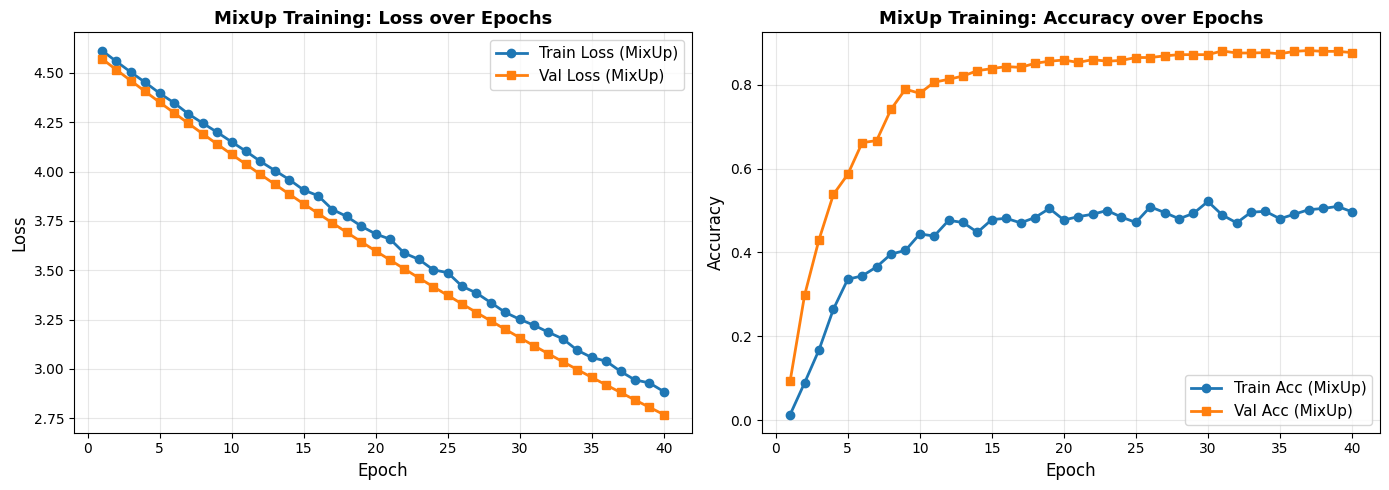

In [17]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

epochs_range = range(1, len(train_losses_mixup) + 1)

# Loss
axes[0].plot(epochs_range, train_losses_mixup, 'o-', label='Train Loss (MixUp)', linewidth=2)
axes[0].plot(epochs_range, val_losses_mixup, 's-', label='Val Loss (MixUp)', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('MixUp Training: Loss over Epochs', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].legend(fontsize=11)

# Acc
axes[1].plot(epochs_range, train_accs_mixup, 'o-', label='Train Acc (MixUp)', linewidth=2)
axes[1].plot(epochs_range, val_accs_mixup, 's-', label='Val Acc (MixUp)', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title('MixUp Training: Accuracy over Epochs', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].legend(fontsize=11)

plt.tight_layout()
plt.show()

print("="*70)